In [36]:
%reload_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dtree import DecisionTree

plt.ioff()

## Part 1: Tennis example

The tennis data comprises of 4 features (Outlook, Temperature, Humidity, Wind) and a label (PlayTennis).

In [2]:
# reading training data
data = pd.read_csv('tennis.csv', header=0)
features = data.columns[:-1]
label = data.columns[-1]
data

,Outlook,Temperature,Humidity,Wind,PlayTennis
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes
5,Rain,Cool,Normal,Strong,No
6,Overcast,Cool,Normal,Strong,Yes
7,Sunny,Mild,High,Weak,No
8,Sunny,Cool,Normal,Weak,Yes
9,Rain,Mild,Normal,Weak,Yes


First, training and testing decision on the same instances as a sanity check.

In [3]:
# creating empty decision tree, demonstrating information gain calculations
d = DecisionTree()
maxig, name, split = d.max_info_gain(data, features, label)
# From observation, the best attribute is Outlook
print(maxig, name)

0.246749819774 Outlook


In [4]:
# training the tree on the loaded data
d.train(data, label)
# after training, the root node should have Outlook attribute, and the child node for Overcase should have a label
print('Root:', d.root)
print('Children:', d.root.children)

Root: Outlook node
Children: {'Overcast': Yes label, 'Rain': Wind node, 'Sunny': Humidity node}


In [5]:
# checking if trained tree perfectly predicts training instances
(d.predict(data) == data[label]).all()

True

Then, splitting the training data in a 4/10 test/train split.

Accuracy: 0.75


<IPython.core.display.Javascript object>


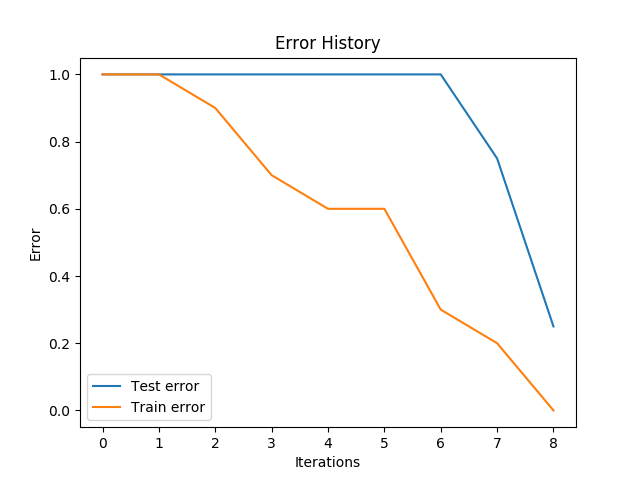

In [6]:
train = data.head(10)  # training set
test = data.tail(4)    # validation set
d = DecisionTree()
hist = d.train(train, label, validation={'test': test, 'train': train})  # training and obtaining error history
print('Accuracy:', (d.predict(test) == test[label]).sum() / len(test))
# plotting
plt.plot(hist['test'], label='Test error')
plt.plot(hist['train'], label='Train error')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Error History')
plt.legend()
plt.show()

## Part 2: Exoplanet Survey Data

The survey is a collection of more than 9000 astronomical observations and their status as confirmed, false positive, or candidate exoplanets. We only consider *confirmed* or *false positive* labels. Additionally, the 14 features are continuous and have large distributions. So as a preprocessing step, the values are scaled logarithmically and discretized into `nbins` categories each.

In [46]:
raw_data = pd.read_csv('exoplanets.csv', header=0)
raw_data = data.sample(frac=1)  # shuffling data
features = raw_data.columns[1:] # feature column names
label = raw_data.columns[0]     # label column name

In [69]:
# preprocessing raw_data by logarithmic scaling and discretization
nbins = 3
data = pd.DataFrame(raw_data[label])
for feature in features:
    _, bins = np.histogram(raw_data[feature], nbins)
    data[feature] = np.digitize(raw_data[feature], bins, right=True)
# splitting into train/test sets
ntrain = 500
ntest = 50
nval = 50
train = data.iloc[:ntrain]
test = data.tail(ntest)

<IPython.core.display.Javascript object>


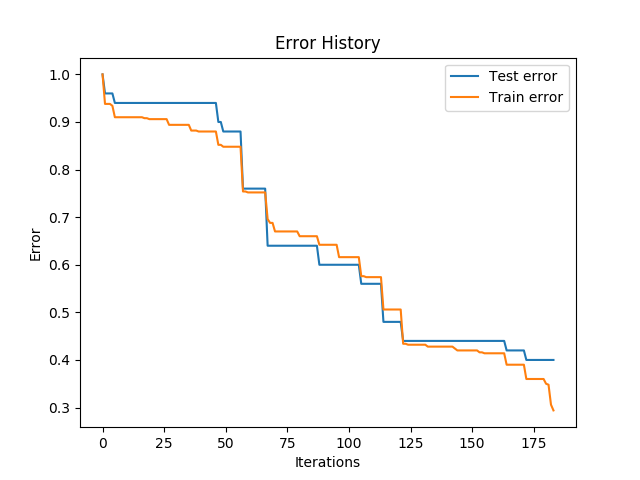

In [70]:
d = DecisionTree()
hist = d.train(train, label, validation={'test': test, 'train': train})
# plotting
plt.plot(hist['test'], label='Test error')
plt.plot(hist['train'], label='Train error')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Error History')
plt.legend()
plt.show()

## Part 3: Pruning

<IPython.core.display.Javascript object>


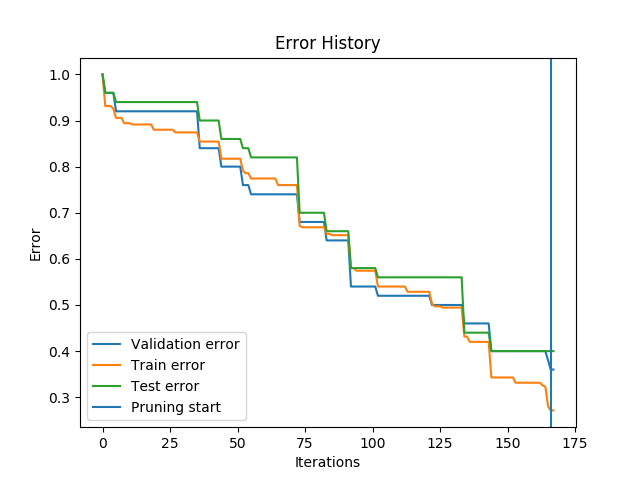

In [73]:
# split training into training/validation
train = train.sample(frac=1)
val = train.iloc[:nval]
train = train.iloc[nval:]
# train on new split
d = DecisionTree()
hist = d.train(train, label, validation={'test': test, 'train': train, 'val': val})
# prune
prune_hist = d.prune(val, label, train, test)
# plotting
plt.plot(hist['val'] + prune_hist[0], label='Validation error')
plt.plot(hist['train'] + prune_hist[1], label='Train error')
plt.plot(hist['test'] + prune_hist[2], label='Test error')
nsteps = len(hist['val'])  # number of steps before pruning
plt.axvline(x=nsteps-1, label='Pruning start')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Error History')
plt.legend()
plt.show()